In [1]:
!nvidia-smi

Sun Jul 13 15:07:00 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.57.01              Driver Version: 565.57.01      CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          On  |   00000000:32:00.0 Off |                    0 |
| N/A   29C    P0             48W /  400W |       1MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [2]:
%matplotlib inline

In [3]:
import pandas as pd
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm import tqdm
import torch
import json
from typing import List, Optional, Dict, Any
import re

## Loading data

In [4]:
# For Snellius
input_csv = "Qwen3_4B_FS_UND.csv"
input_df = pd.read_csv(input_csv)

## Loading the model

In [5]:
Qwen3_4B = "Qwen/Qwen3-4B"

import os
os.environ['TRANSFORMERS_CACHE'] = '/scratch-local/yhuang/huggingface_cache'
# 确保目录存在
os.makedirs('/scratch-local/yhuang/huggingface_cache', exist_ok=True)

In [6]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained(Qwen3_4B, padding_side='left')
model = AutoModelForCausalLM.from_pretrained(Qwen3_4B)

/home/yhuang/sglang-venv-2/lib/python3.11/site-packages/transformers/utils/hub.py:105: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/726 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/99.6M [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/3.99G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/3.96G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

In [7]:
# 将模型移到可用设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)

cuda


## Model function

In [8]:
def batch_generate_responses_qwen3(prompts, system_prompt="You are an expert AI assistant in rating confidence scores.",
                             temperature=0.001, max_new_tokens=512, batch_size=4,
                             enable_thinking=True, parse_thinking=True):
    """
    批量生成Qwen 3模型的回复

    参数:
        prompts: 字符串列表，每个字符串是一个提示词
        system_prompt: 系统提示词
        max_new_tokens: 生成的最大token数，默认为512
        batch_size: 每批处理的提示词数量，默认为4
        enable_thinking: 是否启用思考模式，默认为True
        parse_thinking: 是否解析思考内容，默认为True

    返回:
        如果parse_thinking=True，返回(思考内容列表, 回复内容列表)的元组
        如果parse_thinking=False，返回回复列表
    """

    responses = []
    thinking_contents = [] if parse_thinking else None

    # 按批次处理
    for i in tqdm(range(0, len(prompts), batch_size)):
        batch_prompts = prompts[i:i+batch_size]
        batch_texts = []

        # 为每个提示词准备输入文本
        for prompt in batch_prompts:
            if system_prompt:
                messages = [
                    {"role": "system", "content": system_prompt},
                    {"role": "user", "content": prompt}
                ]
            else:
                messages = [
                    {"role": "user", "content": prompt}
                ]

            text = tokenizer.apply_chat_template(
                messages,
                tokenize=False,
                add_generation_prompt=True,
                enable_thinking=enable_thinking  # 启用思考模式
            )
            batch_texts.append(text)

        # 批量编码输入
        model_inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True).to(model.device)

        # 生成回复
        with torch.no_grad():
            generated_ids = model.generate(
                **model_inputs,
                max_new_tokens=max_new_tokens,
                do_sample=True,
                temperature=temperature,
                top_p=0.9,
                repetition_penalty=1.2
            )

        # 处理生成的回复
        batch_responses = []
        batch_thinking = [] if parse_thinking else None

        for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids):
            response_ids = output_ids[len(input_ids):].tolist()

            if parse_thinking and enable_thinking:
                # 解析思考内容
                try:
                    # 寻找</think>对应的token ID (151668)
                    index = len(response_ids) - response_ids[::-1].index(151668)
                except ValueError:
                    index = 0

                thinking_content = tokenizer.decode(response_ids[:index], skip_special_tokens=True).strip("\n")
                content = tokenizer.decode(response_ids[index:], skip_special_tokens=True).strip("\n")

                batch_thinking.append(thinking_content)
                batch_responses.append(content)
            else:
                # 不解析思考内容，直接返回完整回复
                response = tokenizer.decode(response_ids, skip_special_tokens=True)
                batch_responses.append(response)

        responses.extend(batch_responses)
        if parse_thinking:
            thinking_contents.extend(batch_thinking)

    if parse_thinking:
        return thinking_contents, responses
    else:
        return responses

## Helper functions

In [9]:
def prepare_feedback_prompts_scale(reasoning_list, label="fully specified"):
    consistency_prompt_list = []
    for reasoning in reasoning_list:
        consistency_prompt = f"""
        Given this statement from a reasoning process: "{reasoning}"

        On a scale from 0 to 1, how confident does this statement support
        the classification of a user query as "{label}"?

        Return ONLY a number between 0 and 1. DO NOT PRODUCE ANYTHING ELSE.
        """
        consistency_prompt_list.append(consistency_prompt)
    return consistency_prompt_list

def scale_to_label(scale_list):
  scale_to_label = []
  for scale in scale_list:
    if float(scale) > 0.5:
      scale_to_label.append("fully specified")
    else:
      scale_to_label.append("underspecified")
  return scale_to_label

def get_reasonings_from_responses(responses: List[str]) -> List[Optional[str]]:
    """
    推荐的解析函数，结合了多种方法的优点
    """
    reasonings = []

    for i, response in enumerate(responses):
        reasoning = None

        try:
            # 方法1: 尝试直接解析JSON
            clean_response = response.strip()
            if clean_response.startswith('{') and clean_response.endswith('}'):
                data = json.loads(clean_response)
                reasoning = data.get('reasoning')
            else:
                # 方法2: 寻找JSON部分
                start_idx = clean_response.find('{')
                end_idx = clean_response.rfind('}')
                if start_idx != -1 and end_idx != -1:
                    json_part = clean_response[start_idx:end_idx+1]
                    data = json.loads(json_part)
                    reasoning = data.get('reasoning')

        except json.JSONDecodeError:
            # 方法3: 使用正则表达式作为后备
            pattern = r'"reasoning"\s*:\s*"([^"]*)"'
            match = re.search(pattern, response)
            if match:
                reasoning = match.group(1)

        if reasoning is None:
            print(f"Warning: response {i} cannot retrieve reasoning")
            print(f"Respond content: {response[:200]}...")
            reasoning = "error"

        reasonings.append(reasoning)

    return reasonings

def obtain_results_without(input_csv, filter_set):
    result_df = pd.read_csv(input_csv)
    result_df = result_df[result_df['direct_source']!=filter_set]
    print(classification_report(result_df["gold_judgment"], result_df['model_pred']))

    judgment_gold = result_df['gold_judgment'].tolist()
    judgment_model = result_df["model_pred"].tolist()
    binary_labels = ['underspecified', 'fully specified']

    cm = confusion_matrix(judgment_gold, judgment_model, labels=binary_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=binary_labels)

    disp.plot(cmap='Blues')  # 可以调整 colormap

## Implementation

In [10]:
# Retrieve the reasoning list
response_list = input_df["model_response"].tolist()
reasoning_list = get_reasonings_from_responses(response_list)

# Preparing prompts
feedback_prompts = prepare_feedback_prompts_scale(reasoning_list)
feedback_prompts[21]

'\n        Given this statement from a reasoning process: "The query asks for \'laws\' related to the flow of goods between \'england\' and \'the colonies.\' While the general topic (trade regulation between Britain and its colonial territories) is clear, critical contextual details are missing. Specifically, the query does not specify which colonies (e.g., American colonies vs. Caribbean colonies), the geographic region(s) involved, the time period (e.g., pre-Revolutionary War vs. 19th century), or the type of legal framework (statutes, treaties, regulatory acts). These omissions create ambiguity about which laws to identify, as multiple historical frameworks exist (e.g., Navigation Acts, Molasses Act, Stamp Act)."\n\n        On a scale from 0 to 1, how confident does this statement support\n        the classification of a user query as "fully specified"?\n\n        Return ONLY a number between 0 and 1. DO NOT PRODUCE ANYTHING ELSE.\n        '

100%|██████████| 289/289 [02:45<00:00,  1.75it/s]


                 precision    recall  f1-score   support

fully specified       0.68      0.70      0.69       598
 underspecified       0.67      0.64      0.66       557

       accuracy                           0.67      1155
      macro avg       0.67      0.67      0.67      1155
   weighted avg       0.67      0.67      0.67      1155



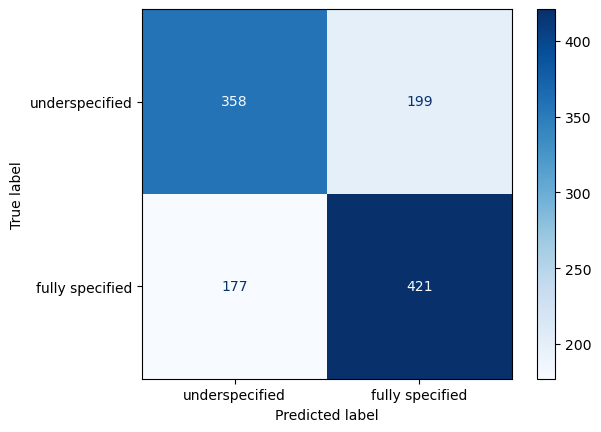

In [17]:
# without-thinking processing
feedback_scale_list = batch_generate_responses_qwen3(feedback_prompts, max_new_tokens=128, enable_thinking=False, parse_thinking=False)
feedback_label_list = scale_to_label(feedback_scale_list)

df = input_df.copy()
df['feedback_scale'] = feedback_scale_list
df['feedback_label'] = feedback_label_list

print(classification_report(df['gold_judgment'], df['feedback_label']))

judgment_gold = df['gold_judgment'].tolist()
judgment_model = df["feedback_label"].tolist()

binary_labels = ['underspecified', 'fully specified']

cm = confusion_matrix(judgment_gold, judgment_model, labels=binary_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=binary_labels)

disp.plot(cmap='Blues')  # 可以调整 colormap

df.to_csv("Qwen3_4B_reasoning_feedback_nothink.csv", index=False)

                 precision    recall  f1-score   support

fully specified       0.73      0.66      0.69       431
 underspecified       0.69      0.75      0.72       424

       accuracy                           0.71       855
      macro avg       0.71      0.71      0.70       855
   weighted avg       0.71      0.71      0.70       855



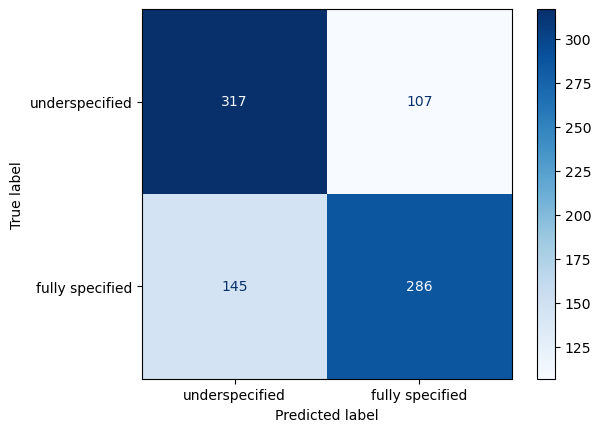

In [18]:
obtain_results_without("Qwen3_4B_reasoning_feedback_nothink.csv", "AmbigQA")

100%|██████████| 289/289 [1:54:46<00:00, 23.83s/it]


                 precision    recall  f1-score   support

fully specified       0.67      0.71      0.69       598
 underspecified       0.67      0.63      0.65       557

       accuracy                           0.67      1155
      macro avg       0.67      0.67      0.67      1155
   weighted avg       0.67      0.67      0.67      1155



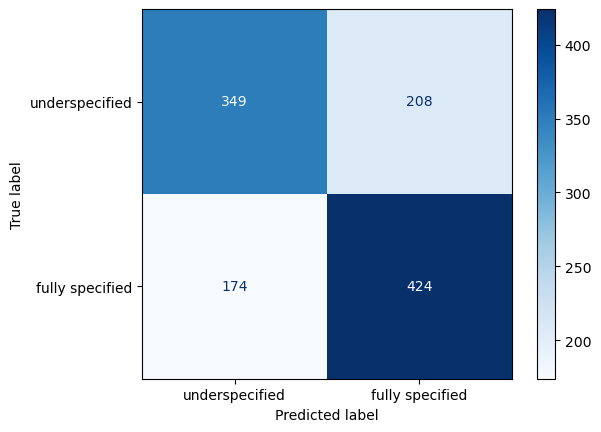

In [11]:
# with_thinking processing
feedback_scale_thinking, feedback_scale_list = batch_generate_responses_qwen3(feedback_prompts,max_new_tokens=30000)
feedback_label_list = scale_to_label(feedback_scale_list)
df = input_df.copy()
df['feedback_scale'] = feedback_scale_list
df['feedback_label'] = feedback_label_list
df['feedback_scale_thinking'] = feedback_scale_thinking

print(classification_report(df['gold_judgment'], df['feedback_label']))

judgment_gold = df['gold_judgment'].tolist()
judgment_model = df["feedback_label"].tolist()

binary_labels = ['underspecified', 'fully specified']

cm = confusion_matrix(judgment_gold, judgment_model, labels=binary_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=binary_labels)

disp.plot(cmap='Blues')  # 可以调整 colormap

df.to_csv("Qwen3_4B_reasoning_feedback_think.csv", index=False)

                 precision    recall  f1-score   support

fully specified       0.73      0.66      0.69       431
 underspecified       0.69      0.75      0.72       424

       accuracy                           0.71       855
      macro avg       0.71      0.71      0.70       855
   weighted avg       0.71      0.71      0.70       855



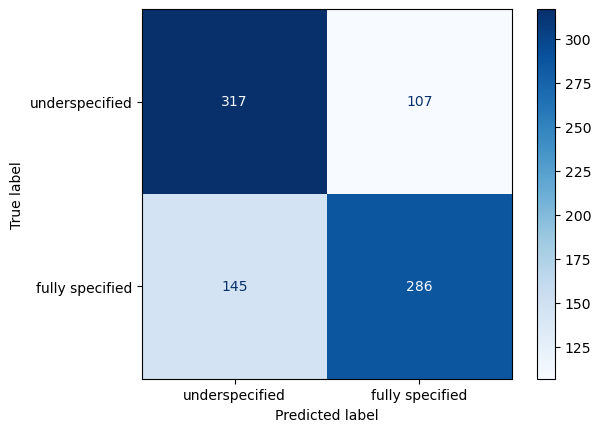

In [12]:
obtain_results_without("Qwen3_4B_reasoning_feedback_think.csv", "AmbigQA")